# Experiment

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.stats import randint, uniform
import time
from sklearn.feature_selection import f_regression, SelectKBest

## Import the Original Dataset

In [2]:
data = pd.read_csv("ibovFinal.csv")
data['Date'] = pd.to_datetime(data['Date'])

data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Volume_Variation,Close_Lag_1,Open_Lag_1,...,IMA-B,Currency_in_circulation,Bank_Reserves,Restricted_monetary_base,EMBI+,Log_Returns,VaR_10day,CVaR_10day,Std_Dev_Returns_10day,MDD_10day
3210,2023-05-09,106028.0,107731.0,105549.0,107114.0,107114.0,13526600,2.016713,106042.0,105161.0,...,9109.864713,328799127.0,70195045.0,398994172.0,258.0,0.010058,-0.022889,-0.024279,0.014474,-0.025525
3211,2023-05-10,107114.0,107744.0,106538.0,107448.0,107448.0,13576900,0.371860,107114.0,106028.0,...,9135.109719,328420661.0,64927269.0,393347931.0,261.0,0.003113,-0.022889,-0.024279,0.014043,-0.025525
3212,2023-05-11,107446.0,108667.0,106419.0,108256.0,108256.0,12772100,-5.927715,107448.0,107114.0,...,9166.513823,327874530.0,70914194.0,398788723.0,261.0,0.007492,-0.022209,-0.024279,0.013313,-0.025525
3213,2023-05-12,108256.0,108817.0,107497.0,108464.0,108464.0,0,-100.000000,108256.0,107446.0,...,9206.795828,327264580.0,71751464.0,399016044.0,258.0,0.001920,-0.022209,-0.024279,0.013363,-0.025525
3214,2023-05-15,108469.0,109271.0,108356.0,109029.0,109029.0,11603200,0.000000,108464.0,108256.0,...,9237.299405,326685715.0,67909883.0,394595598.0,258.0,0.005196,-0.022209,-0.024279,0.012960,-0.025525
3215,2023-05-16,109029.0,110151.0,108085.0,108194.0,108194.0,16897300,45.626207,109029.0,108469.0,...,9213.440940,326217601.0,68277079.0,394494680.0,253.0,-0.007688,-0.007111,-0.007688,0.009492,-0.007688
3216,2023-05-17,108194.0,109774.0,108188.0,109460.0,109460.0,13993000,-17.187953,108194.0,109029.0,...,9213.802638,325605415.0,70135062.0,395740477.0,252.0,0.011633,-0.006823,-0.007688,0.009273,-0.007688
3217,2023-05-18,109459.0,110206.0,108864.0,110108.0,110108.0,13613100,-2.714929,109460.0,108194.0,...,9205.759195,325296848.0,70150064.0,395446912.0,246.0,0.005903,-0.006823,-0.007688,0.009205,-0.007688
3218,2023-05-19,110113.0,111211.0,109787.0,110745.0,110745.0,16135800,18.531415,110108.0,109459.0,...,9213.470092,324959571.0,73470194.0,398429765.0,244.0,0.005769,-0.006823,-0.007688,0.005405,-0.007688
3219,2023-05-22,110745.0,111643.0,110178.0,110213.0,110213.0,11769400,-27.060325,110745.0,110113.0,...,9196.683762,324574188.0,66096822.0,390671010.0,242.0,-0.004815,-0.007429,-0.007688,0.006097,-0.007688


### Columns

In [3]:
print(", ".join(data.columns.tolist()))

Date, Open, High, Low, Close, Adj Close, Volume, Volume_Variation, Close_Lag_1, Open_Lag_1, High_Lag_1, Low_Lag_1, Close_Lag_2, Open_Lag_2, High_Lag_2, Low_Lag_2, Close_Lag_3, Open_Lag_3, High_Lag_3, Low_Lag_3, Close_Lag_4, Open_Lag_4, High_Lag_4, Low_Lag_4, Close_Lag_5, Open_Lag_5, High_Lag_5, Low_Lag_5, Price_Change, RSI, SMA_10, SMA_30, SMA_100, OBV, EMA_10, EMA_30, EMA_100, MACD, MACD_Signal, CP_Standard_Deviation, Middle_Band, Upper_Band, Lower_Band, MFI, Williams_%R, SP500, DJIA, NASDAQ, NYSE, FTSE100, DAX, CAC40, NIKKEI, HSI, ASX200, KOSPI, TSEC, SSECI, Shenzhen, Vix, USD/BRL, GBP/BRL, EUR/BRL, Gold, Silver, Crude_Oil, Copper, Natural_Gas, Corn, Soy, Wheat, Live_Cattle, Coffee, Selic_Target, Selic_Daily, CDI, IMA-S, IRF-M, IMA-B, Currency_in_circulation, Bank_Reserves, Restricted_monetary_base, EMBI+, Log_Returns, VaR_10day, CVaR_10day, Std_Dev_Returns_10day, MDD_10day


### Remove columns that are not used (the dataset is already ordered by date)

In [5]:
# List of columns to be deleted 
delete_columns = [
      'Date', 'Close', 'Adj Close', 'Log_Returns', 'VaR_10day', 
      'Std_Dev_Returns_10day', 'CVaR_10day'
]

# Excluindo as colunas
data = data.drop(columns=delete_columns) 

### Prection Target

In [6]:
# Define the target column
target_column = 'MDD_10day'

### Feature Selection by F-Test

In [7]:
# Separate the predictors (features) and the target
X = data.drop(columns=[target_column])
y = data[target_column]

# Apply F-test to select the K best features
k_best = 10  
selector = SelectKBest(score_func=f_regression, k=k_best)
X_selected = selector.fit_transform(X, y)

# Get indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Names of the selected features
selected_features_f_reg = X.columns[selected_feature_indices].tolist()
print(f'The {k_best} best features selected by the F-test:\n', selected_features_f_reg)

The 10 best features selected by the F-test:
 ['RSI', 'MACD', 'MACD_Signal', 'CP_Standard_Deviation', 'MFI', 'Williams_%R', 'FTSE100', 'HSI', 'Vix', 'EMBI+']


### Feature Selection by Correlation

In [8]:
# Calculate Pearson and Spearman correlations
pearson_corr = X.corrwith(y, method='pearson')
spearman_corr = X.corrwith(y, method='spearman')

# Define the number of best features to be selected
k_best = 10 

# Select the top k features based on Pearson correlation
top_pearson_features = pearson_corr.abs().sort_values(ascending=False).head(k_best).index.tolist()
print(f'The {k_best} best features selected by Pearson correlation:\n', top_pearson_features)

# Select the top k features based on Spearman correlation
top_spearman_features = spearman_corr.abs().sort_values(ascending=False).head(k_best).index.tolist()
print(f'The {k_best} best features selected by Spearman correlation:\n', top_spearman_features)

# Select the features that appear in both methods
common_features = set(top_pearson_features).intersection(set(top_spearman_features))
print(f'Common features selected by Pearson and Spearman:\n', list(common_features))

# Select the union of features that appear in both methods
all_features_correlation = set(top_pearson_features).union(set(top_spearman_features))
print(f'All features selected by Pearson and Spearman:\n', list(all_features_correlation))

The 10 best features selected by Pearson correlation:
 ['MACD', 'Vix', 'MACD_Signal', 'CP_Standard_Deviation', 'RSI', 'Williams_%R', 'MFI', 'EMBI+', 'FTSE100', 'HSI']
The 10 best features selected by Spearman correlation:
 ['RSI', 'Williams_%R', 'MACD', 'MFI', 'MACD_Signal', 'Vix', 'FTSE100', 'Low', 'HSI', 'Low_Lag_1']
Common features selected by Pearson and Spearman:
 ['Williams_%R', 'HSI', 'Vix', 'MFI', 'MACD_Signal', 'MACD', 'FTSE100', 'RSI']
All features selected by Pearson and Spearman:
 ['Low', 'HSI', 'Vix', 'EMBI+', 'MFI', 'MACD', 'FTSE100', 'Low_Lag_1', 'Williams_%R', 'CP_Standard_Deviation', 'MACD_Signal', 'RSI']


### Defining the list of selected features

In [9]:
# List of features and target
final_list_test_f = selected_features_f_reg + [target_column]
final_list_test_pearson = top_pearson_features + [target_column]
final_list_test_spearman = top_spearman_features + [target_column]
final_list_test_common = list(common_features) + [target_column]
final_list_test_all = list(set(selected_features_f_reg) | set(all_features_correlation) | {target_column})

# Select only the features chosen by each method
data_test_f = data[final_list_test_f]
data_test_pearson = data[final_list_test_pearson]
data_test_spearman = data[final_list_test_spearman]
data_test_common = data[final_list_test_common]
data_test_all = data[final_list_test_all]
data_test_vix = data[["Vix", target_column]]

### Splitting the data

In [10]:
# Function to split training and testing data
def split_data(data, target_column):
    train_set, test_set = np.split(data, [int(.80 * len(data))])
    X_train = train_set.drop(columns=[target_column])
    y_train = train_set[target_column]
    X_test = test_set.drop(columns=[target_column])
    y_test = test_set[target_column]
    return X_train, y_train, X_test, y_test

# Split the datasets into train and test
X_train_f, y_train_f, X_test_f, y_test_f = split_data(data_test_f, target_column)
X_train_pearson, y_train_pearson, X_test_pearson, y_test_pearson = split_data(data_test_pearson, target_column)
X_train_spearman, y_train_spearman, X_test_spearman, y_test_spearman = split_data(data_test_spearman, target_column)
X_train_common, y_train_common, X_test_common, y_test_common = split_data(data_test_common, target_column)
X_train_all, y_train_all, X_test_all, y_test_all = split_data(data_test_all, target_column)
X_train_original, y_train_original, X_test_original, y_test_original = split_data(data, target_column)
X_train_vix, y_train_vix, X_test_vix, y_test_vix = split_data(data_test_vix, target_column)

C:\Users\stutz\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\stutz\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\stutz\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\stutz\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\stutz\anaconda3\Lib\site-packages\numpy\core\fr

### Datasets Dictionary

In [11]:
# Mapping of models to datasets
datasets = {
    'f': (X_train_f, y_train_f, X_test_f, y_test_f),
    'pearson': (X_train_pearson, y_train_pearson, X_test_pearson, y_test_pearson),
    'spearman': (X_train_spearman, y_train_spearman, X_test_spearman, y_test_spearman),
    'common': (X_train_common, y_train_common, X_test_common, y_test_common),
    'all_selection': (X_train_all, y_train_all, X_test_all, y_test_all),
    'original': (X_train_original, y_train_original, X_test_original, y_test_original),
    'vix': (X_train_vix, y_train_vix, X_test_vix, y_test_vix)
}

### Target Statistics

In [12]:
data[target_column].describe()

count    3220.000000
mean       -0.041893
std         0.036405
min        -0.411931
25%        -0.052014
50%        -0.034714
75%        -0.020368
max         0.000000
Name: MDD_10day, dtype: float64

### Evaluation Function 

In [15]:
# Function for model evaluation
def evaluate_model(name, model, X_train, y_train, X_test, y_test, data='f', fit_params=None):
    start_time = time.time()
    if fit_params is None:
        fit_params = {}
    model.fit(X_train, y_train, **fit_params)
    train_time = time.time() - start_time

    start_time = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predict_time = time.time() - start_time

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results = {
        "train_time": train_time,
        "predict_time": predict_time,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    }

    print(f"\nResults for {name} ({data}):")
    print(f"Training Time: {results['train_time']:.4f} seconds")
    print(f"Prediction Time: {results['predict_time']:.4f} seconds")
    print(f"Train MAE: {results['train_mae']:.4f}")
    print(f"Test MAE: {results['test_mae']:.4f}")
    print(f"Train RMSE: {results['train_rmse']:.4f}")
    print(f"Test RMSE: {results['test_rmse']:.4f}")

    return results, y_train_pred, y_test_pred


### Plot Function - Predicted vs Actual

In [16]:
# Function to plot the prediction results
def plot_prediction_results(name, y_train, y_train_pred, y_test, y_test_pred):
    plt.figure(figsize=(14, 7))

    plt.plot(range(len(y_test)), y_test, label='True Values', color='black', linewidth=3, alpha=0.6)
    plt.plot(range(len(y_test)), y_test_pred, label='Predicted Values', color='#0f8bf0', linewidth=3)
    plt.xlabel("Iteration", fontsize=24)
    plt.ylabel("Max Drawdown", fontsize=24)
    
    plt.legend(fontsize=22)
    
    plt.xticks(fontsize=20) 
    plt.yticks(fontsize=20)  
    
    plt.tight_layout()
    
    plt.show()

### Train and Evaluate Function

In [17]:
# Function to train and evaluate the model
def train_and_evaluate(model_name, model, data_key='f', plot=False, fit_params=None):
    if data_key not in datasets:
        print(f"Dataset '{data_key}' not found.")
        return
    X_train, y_train, X_test, y_test = datasets[data_key]
    results, y_train_pred, y_test_pred = evaluate_model(model_name, model, X_train, y_train, X_test, y_test, data=data_key, fit_params=fit_params)
    if plot == True:
        plot_prediction_results(model_name, y_train, y_train_pred, y_test, y_test_pred)
    return results, y_train_pred, y_test_pred


### Shap Function

In [18]:
# Função para calcular e plotar SHAP values
def calculate_and_plot_shap(model, X_train, feature_names, model_name):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)

    # Summary plot
    shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
    plt.show()

    # Dependence plot for the most important feature
    most_important_feature = feature_names[np.argmax(np.abs(shap_values.values).mean(axis=0))]
    shap.dependence_plot(most_important_feature, shap_values.values, X_train, feature_names=feature_names, show=False)
    plt.show()


## Adaboost

Training AdaBoost...

Results for AdaBoost (common):
Training Time: 0.7618 seconds
Prediction Time: 0.0443 seconds
Train MAE: 0.0178
Test MAE: 0.0250
Train RMSE: 0.0208
Test RMSE: 0.0317


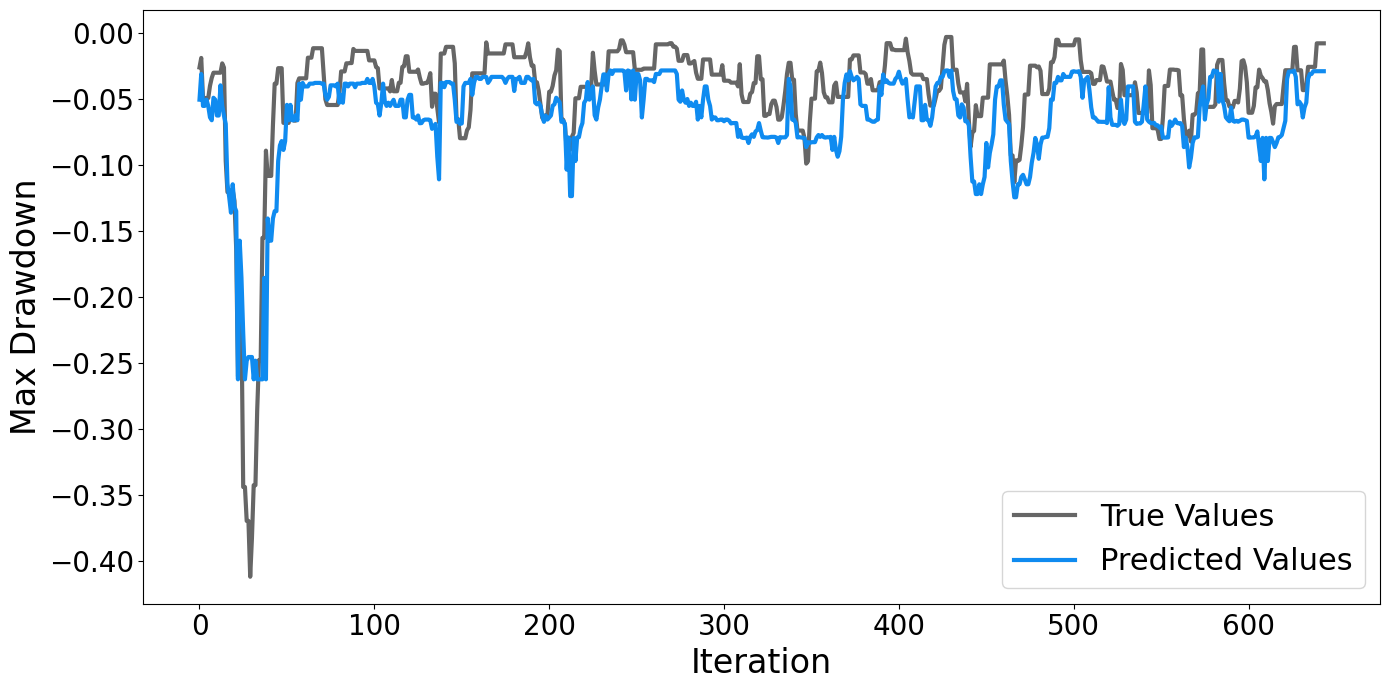

In [19]:
# Instantiate and train adaboost
adaboost = AdaBoostRegressor()

print("Training AdaBoost...")
train_and_evaluate("AdaBoost", adaboost, data_key='common', plot=True)

feature_importance = adaboost.feature_importances_

### Adaboost Feature Importance

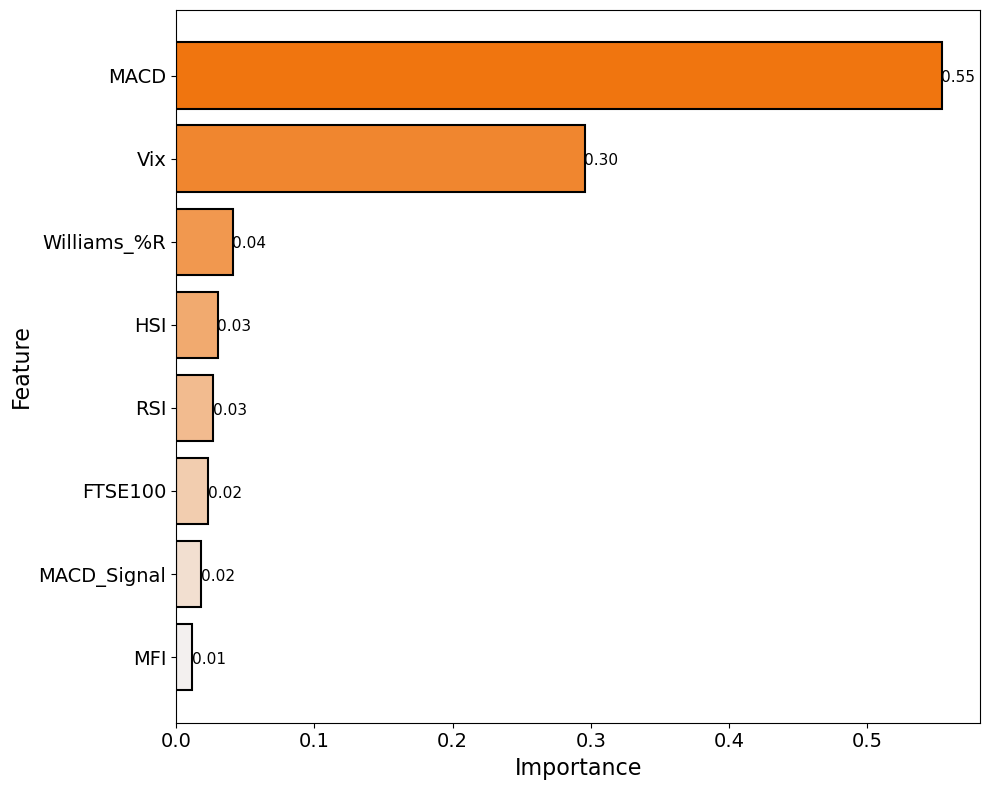

In [20]:
# Create a DataFrame with feature importances and their names
feature_importance_df = pd.DataFrame(list(zip(X_train_common.columns, feature_importance)),
                                     columns=['Feature', 'Importance'])

# Sort the DataFrame by feature importances (ascending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Define the colors for the gradient
color = '#f0750f'
color_light = '#ffb46e'

# Create the bar plot with Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate the linear gradient
n = len(feature_importance_df)
colors = sns.light_palette(color, n_colors=n, reverse=False).as_hex()

# Plot the feature importances
bars = ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
               color=colors, edgecolor='black', linewidth=1.5)

# Add annotations to the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.012, bar.get_y() + bar.get_height() / 2. - 0.08,
            '{:1.2f}'.format(width), ha="center", fontsize=11)

# Plot settings
#ax.set_title('Feature Importances - AdaBoost', fontsize=16)
ax.set_xlabel('Importance', fontsize=16)
ax.set_ylabel('Feature', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('feature-importance-cvar.svg', format='svg')
plt.show()


## Gradient Boosting

Training Gradient Boosting...

Results for Gradient Boosting (all_selection):
Training Time: 5.8777 seconds
Prediction Time: 0.0099 seconds
Train MAE: 0.0082
Test MAE: 0.0162
Train RMSE: 0.0110
Test RMSE: 0.0306


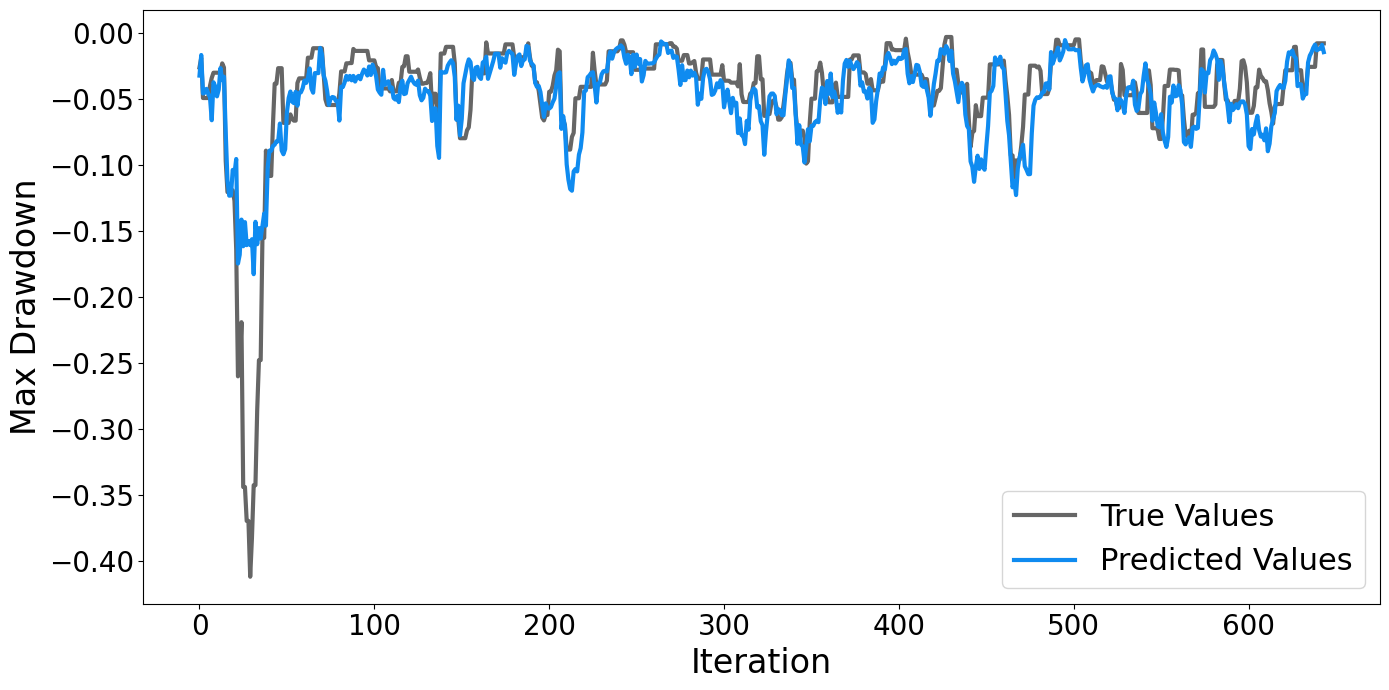

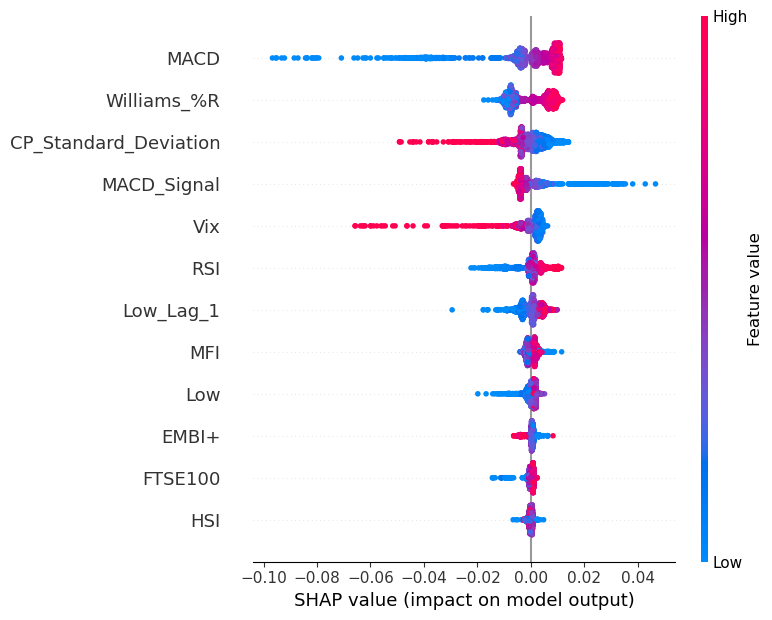

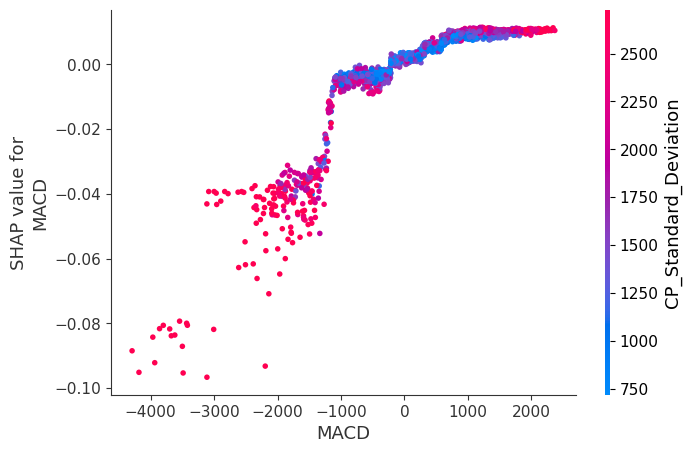

In [21]:
# Instantiate and train gradient boosting
gradient_boosting = GradientBoostingRegressor()

print("Training Gradient Boosting...")
train_and_evaluate("Gradient Boosting", gradient_boosting, data_key='all_selection', plot=True)

calculate_and_plot_shap(gradient_boosting, X_train_all, X_train_all.columns, 'Gradient Boosting')

## XGBoost

Training XGBoost...

Results for XGBoost (vix):
Training Time: 0.1814 seconds
Prediction Time: 0.0085 seconds
Train MAE: 0.0186
Test MAE: 0.0235
Train RMSE: 0.0254
Test RMSE: 0.0338


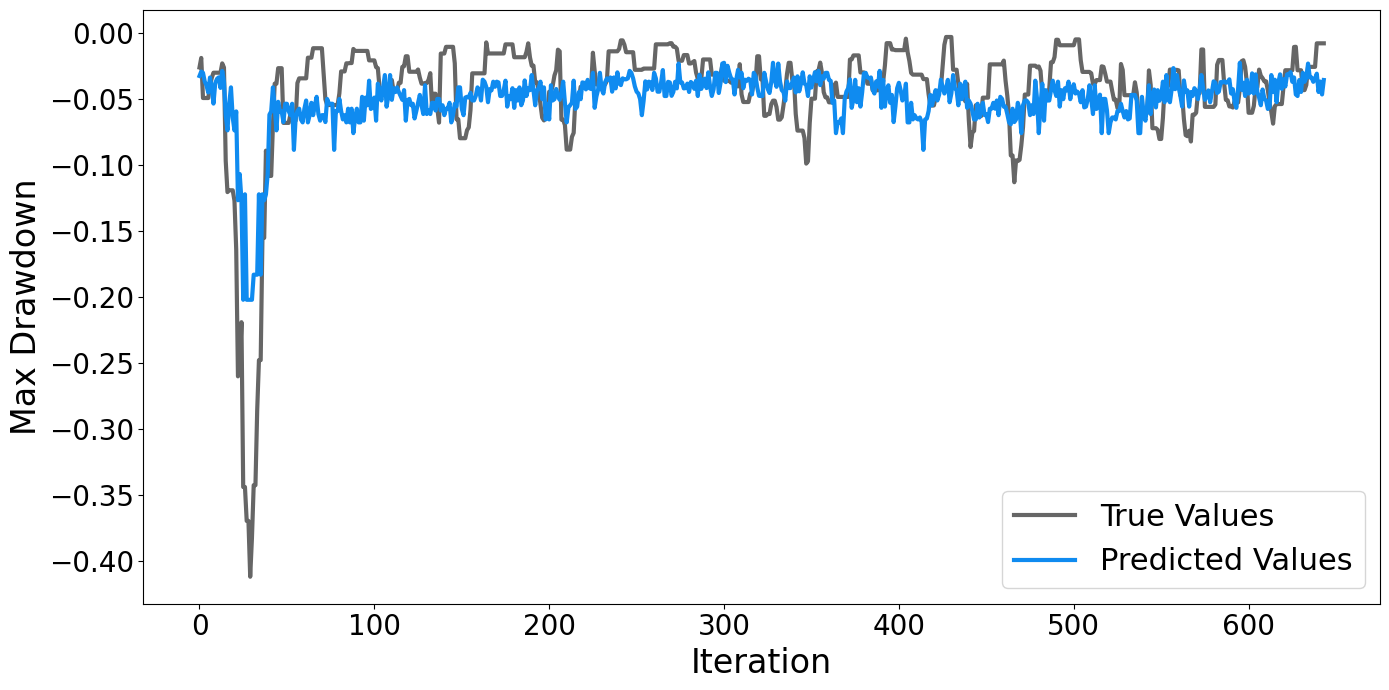

({'train_time': 0.18139410018920898,
  'predict_time': 0.00854349136352539,
  'train_mae': 0.018579988285783187,
  'test_mae': 0.023515549905681322,
  'train_rmse': 0.025404885788152733,
  'test_rmse': 0.03375836025712514},
 array([-0.03223856, -0.03244408, -0.0231839 , ..., -0.03158452,
        -0.04033633, -0.02968199], dtype=float32),
 array([-0.03244408, -0.02907377, -0.0300327 , -0.03666007, -0.03961186,
        -0.04490361, -0.03361578, -0.04167623, -0.05336233, -0.03790446,
        -0.03462551, -0.0334896 , -0.04147359, -0.0286155 , -0.03685822,
        -0.06213132, -0.07364628, -0.05348557, -0.04106148, -0.06389201,
        -0.07364628, -0.05929061, -0.12660751, -0.10675218, -0.12660751,
        -0.20203854, -0.12210773, -0.20203854, -0.20203854, -0.20203854,
        -0.20203854, -0.18302782, -0.18302782, -0.18302782, -0.12210773,
        -0.18302782, -0.12210773, -0.12660751, -0.12210773, -0.10675218,
        -0.06174965, -0.05929061, -0.04106148, -0.0555073 , -0.07364628,
   

In [22]:
# Instantiate and train xgboost
xgboost = xgb.XGBRegressor()

print("Training XGBoost...")
train_and_evaluate("XGBoost", xgboost, data_key='vix', plot=True)

## LightGBM

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2576, number of used features: 10
[LightGBM] [Info] Start training from score -0.041341

Results for LightGBM (spearman):
Training Time: 0.7680 seconds
Prediction Time: 0.0530 seconds
Train MAE: 0.0048
Test MAE: 0.0146
Train RMSE: 0.0069
Test RMSE: 0.0246


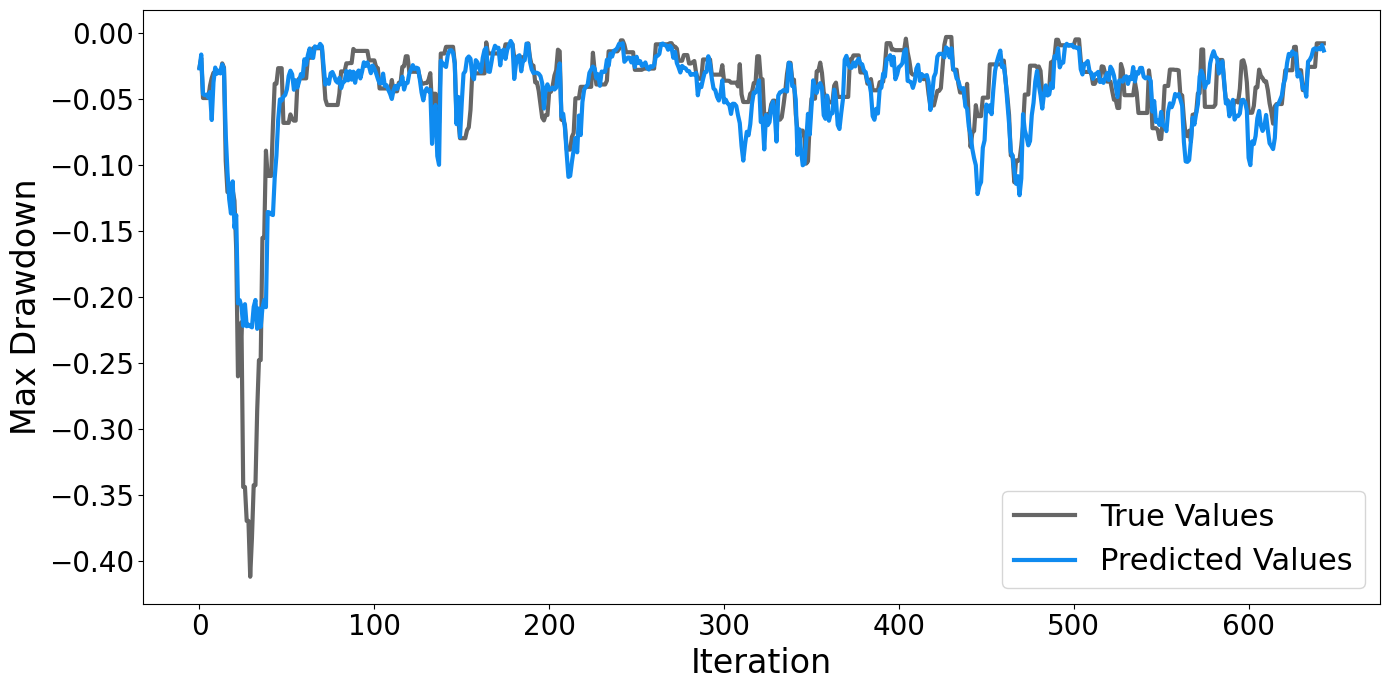

 98%|===================| 2533/2576 [00:25<00:00]        

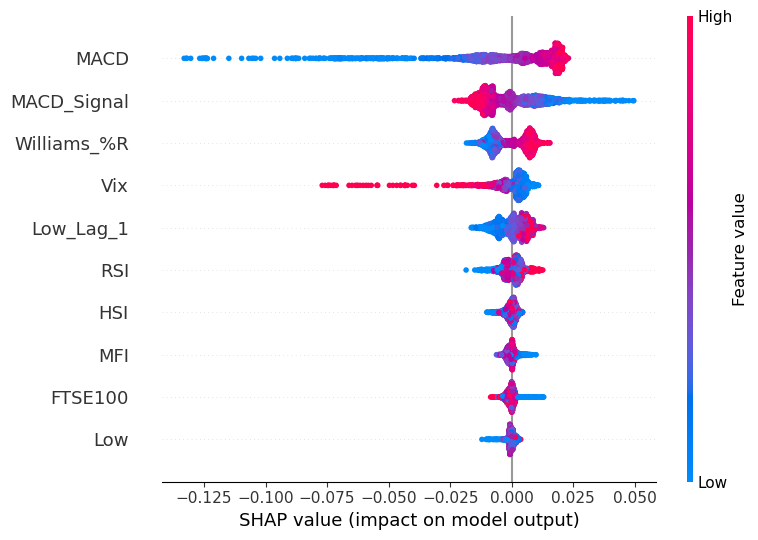

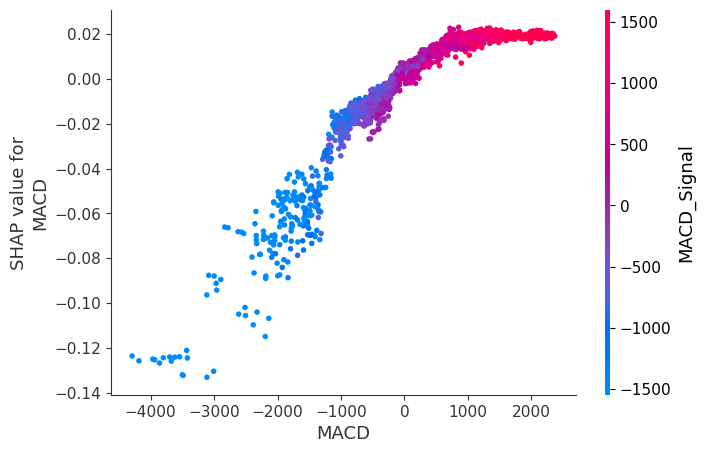

In [23]:
# Instantiate and train lightgbm
lightgbm = lgb.LGBMRegressor()

print("Training LightGBM...")
train_and_evaluate("LightGBM", lightgbm, data_key='spearman', plot=True)

calculate_and_plot_shap(lightgbm, X_train_spearman, X_train_spearman.columns, 'LightGBM')


## Catboost

Training CatBoost...
Learning rate set to 0.047545
0:	learn: 0.0325243	total: 146ms	remaining: 2m 25s
1:	learn: 0.0320864	total: 148ms	remaining: 1m 14s
2:	learn: 0.0316624	total: 151ms	remaining: 50.1s
3:	learn: 0.0312544	total: 154ms	remaining: 38.4s
4:	learn: 0.0308977	total: 157ms	remaining: 31.2s
5:	learn: 0.0305871	total: 159ms	remaining: 26.3s
6:	learn: 0.0302757	total: 161ms	remaining: 22.8s
7:	learn: 0.0300035	total: 164ms	remaining: 20.3s
8:	learn: 0.0297465	total: 166ms	remaining: 18.3s
9:	learn: 0.0295081	total: 168ms	remaining: 16.6s
10:	learn: 0.0292739	total: 169ms	remaining: 15.2s
11:	learn: 0.0290593	total: 172ms	remaining: 14.1s
12:	learn: 0.0288782	total: 173ms	remaining: 13.1s
13:	learn: 0.0286874	total: 175ms	remaining: 12.4s
14:	learn: 0.0285213	total: 178ms	remaining: 11.7s
15:	learn: 0.0283777	total: 180ms	remaining: 11.1s
16:	learn: 0.0282350	total: 183ms	remaining: 10.6s
17:	learn: 0.0281094	total: 185ms	remaining: 10.1s
18:	learn: 0.0279809	total: 187ms	remai

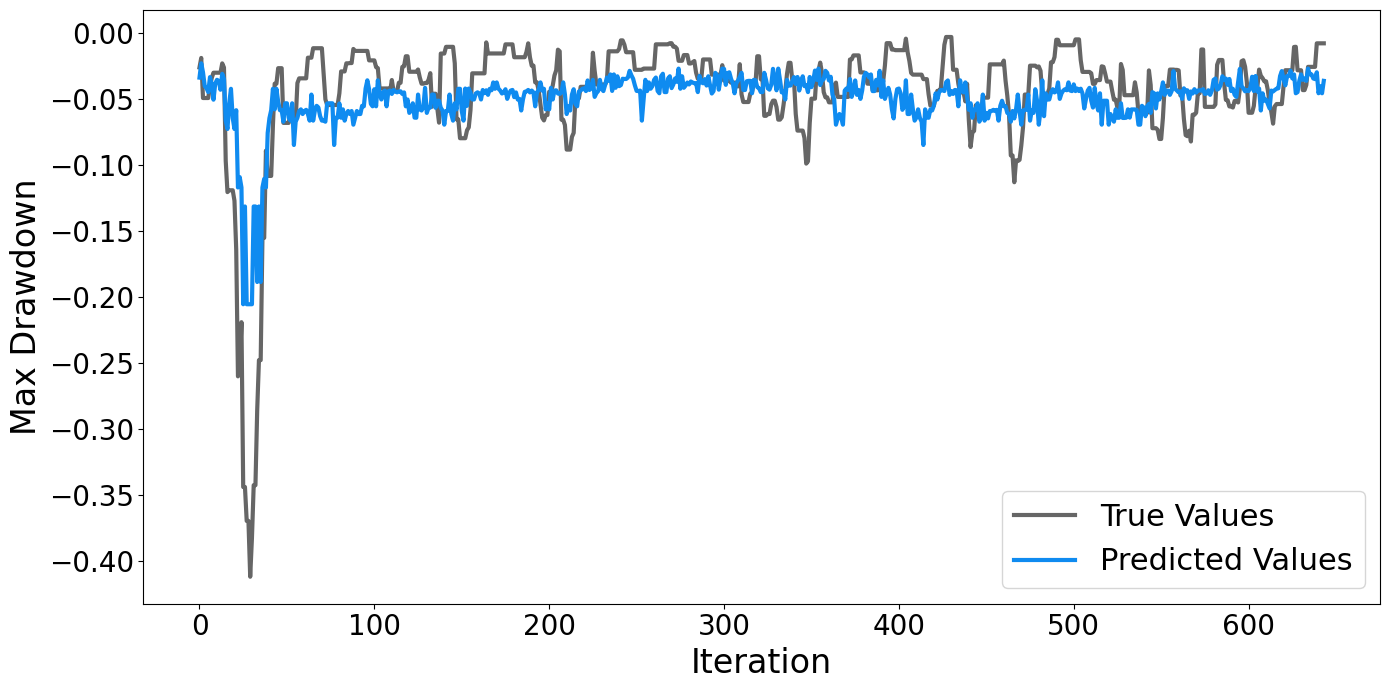

({'train_time': 3.127399444580078,
  'predict_time': 0.03577613830566406,
  'train_mae': 0.018800118937767507,
  'test_mae': 0.02320963095740036,
  'train_rmse': 0.02554470391459337,
  'test_rmse': 0.0340453484599418},
 array([-0.02963156, -0.03368899, -0.03686337, ..., -0.02618952,
        -0.03628972, -0.02555595]),
 array([-0.03368899, -0.02283647, -0.02964181, -0.04012932, -0.04164528,
        -0.0446685 , -0.03330047, -0.03848465, -0.05040033, -0.03829892,
        -0.03532284, -0.03620956, -0.0428587 , -0.03082117, -0.03480879,
        -0.06627181, -0.07260165, -0.05313436, -0.04215426, -0.06424094,
        -0.07260165, -0.05837206, -0.11692298, -0.10909377, -0.11692298,
        -0.20542345, -0.13132276, -0.20542345, -0.20542345, -0.20542345,
        -0.20542345, -0.13132276, -0.13132276, -0.18856803, -0.13132276,
        -0.18856803, -0.11692298, -0.11043669, -0.11692298, -0.07560295,
        -0.06440998, -0.05837206, -0.04215426, -0.05771688, -0.04215426,
        -0.05199255, -0

In [24]:
# Instantiate and train catboost
catboost = CatBoostRegressor()

print("Training CatBoost...")
train_and_evaluate("CatBoost", catboost, data_key='vix', plot=True)


### Aggregated results without hyperparameter tuning

In [26]:
# Lista of models and parameters
models = [
    ("AdaBoost", AdaBoostRegressor(), 'f', False, None),
    ("Gradient Boosting", GradientBoostingRegressor(), 'f', False, None),
    ("XGBoost", xgb.XGBRegressor(), 'f', False, None),
    ("LightGBM", lgb.LGBMRegressor(), 'f', False, None),
    ("CatBoost", catboost, 'f', False, None)
]

# Loop to train and evalute the models
for model_name, model_instance, data_key, plot_flag, fit_params in models:
    print(f"Training {model_name}...")
    train_and_evaluate(model_name, model_instance, data_key=data_key, plot=plot_flag, fit_params=fit_params)
    

Training AdaBoost...

Results for AdaBoost (f):
Training Time: 0.8415 seconds
Prediction Time: 0.0424 seconds
Train MAE: 0.0160
Test MAE: 0.0255
Train RMSE: 0.0187
Test RMSE: 0.0324
Training Gradient Boosting...

Results for Gradient Boosting (f):
Training Time: 4.8760 seconds
Prediction Time: 0.0119 seconds
Train MAE: 0.0084
Test MAE: 0.0243
Train RMSE: 0.0113
Test RMSE: 0.0332
Training XGBoost...

Results for XGBoost (f):
Training Time: 0.5316 seconds
Prediction Time: 0.0131 seconds
Train MAE: 0.0013
Test MAE: 0.0233
Train RMSE: 0.0018
Test RMSE: 0.0361
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2576, number of used features: 10
[LightGBM] [Info] Start training from score -0.041341

Results for LightGBM (f):
Training Time: 0.3978 seconds
Prediction Time: 0

### Results with hyperparameter tuning

In [27]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Definition of hyperparameter spaces for each model
random_search_params = {
    "AdaBoost": {
        'n_estimators': randint(5, 200),        
        'learning_rate': uniform(0.01, 0.5) 
    },
    "Gradient Boosting": {
        "n_estimators": randint(5, 200),
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(1, 6)
    },
    "XGBoost": {
        "n_estimators": randint(5, 200), 
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(1, 6),
        "reg_lambda": randint(0, 5),
        "gamma": uniform(0, 1),
    },
    "LightGBM": {
        "n_estimators": randint(5, 200), 
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(1, 6),
        "num_leaves": randint(10, 40),
        "reg_lambda": randint(0, 5)
    },
    "CatBoost": {
        "iterations": randint(5, 200), 
        "learning_rate": uniform(0.01, 0.5),
        "max_depth":  randint(1, 6),
        "l2_leaf_reg": randint(0, 5),
        "random_strength": randint(0, 5)
    }
}

# List of models and their original parameters
models = [
    ("AdaBoost", AdaBoostRegressor(), 'f', False, None),
    ("Gradient Boosting", GradientBoostingRegressor(), 'f', False, None),
    ("XGBoost", xgb.XGBRegressor(), 'f', False, None),
    ("LightGBM", lgb.LGBMRegressor(verbosity=-1), 'f', False, None),
    ("CatBoost", CatBoostRegressor(verbose=False), 'f', False, None)
]

# Dictionary to store the results
results_dict = {}

# Loop to train and evaluate all models with Randomized Search and Time Series Cross-Validation
for model_name, model_instance, data_key, plot_flag, fit_params in models:
    print(f"Training {model_name} with Randomized Search and Time Series CV...")

    if model_name in random_search_params:
        param_dist = random_search_params[model_name]
        
        # Define the evaluation metric as RMSE
        scoring = make_scorer(rmse, greater_is_better=False)
        
        # Create the TimeSeriesSplit object for time series cross-validation
        tscv = TimeSeriesSplit(n_splits=10)  
        
        # Get the data corresponding to the data_key
        X_train, y_train, X_test, y_test = datasets[data_key]
        
        # Create the RandomizedSearchCV object
        random_search = RandomizedSearchCV(estimator=model_instance, param_distributions=param_dist, 
                                           scoring=scoring, cv=tscv, n_iter=100, verbose=1)
        
        # Perform the random search
        random_search.fit(X_train, y_train)
        
        # Best parameters found
        best_params = random_search.best_params_
        print(f"Best Parameters for {model_name}: {best_params}")
        
        # Evaluate the model with the best parameters
        model_instance.set_params(**best_params)  # Set the model with the best parameters found
        model_instance.fit(X_train, y_train)
        
        # Evaluation on the test set
        y_pred = model_instance.predict(X_test)
        test_rmse = rmse(y_test, y_pred)
        
        # Store the results
        results_dict[model_name] = {
            'best_params': best_params,
            'test_rmse': test_rmse
        }
    else:
        print(f"Randomized Search not defined for {model_name}. Using the standard parameters.")
        model_instance.fit(X_train, y_train)
        y_pred = model_instance.predict(X_test)
        test_rmse = rmse(y_test, y_pred)
        results_dict[model_name] = {
            'best_params': None,
            'test_rmse': test_rmse
        }

# Print the results ordered by RMSE (increasing)
print("\nModels ordered by RMSE (increasing):")
sorted_results = sorted(results_dict.items(), key=lambda x: x[1]['test_rmse']) 
for model_name, result_dict in sorted_results:
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result_dict['best_params']}")
    print(f"Test RMSE: {result_dict['test_rmse']:.4f}\n")


Training AdaBoost with Randomized Search and Time Series CV...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 